# Wine Case Analysis: *Wine Spectator*'s Top 100 Wines, 1988-2020
List available online on *Wine Spectator*'s [Top 100 Lists web site](https://top100.winespectator.com/lists/).

## File Setup

In [294]:
# import and initialize main python libraries
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import bar_chart_race as bcr
import seaborn as sns

# import libraries for file navigation
import os
import shutil
import glob
from pandas_ods_reader import read_ods

# import other packages
from scipy import stats
from sklearn import linear_model

# import geo packages
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon

# import Geopy packages
import geopy
from geopy.geocoders import Nominatim

In [295]:
# initialize vizualization set
sns.set(style="whitegrid", palette="colorblind", color_codes=True)
sns.mpl.rc("figure", figsize=(10, 6))

# Jupyter Notebook
%matplotlib inline

## Dataframe Exploration

In [296]:
# Note: save CSV files in UTF-8 format to preserve special characters.
df_Wine = pd.read_csv('./Wine_Hier01.csv')
df_GeoCache = pd.read_csv('./GeoCache.csv')
df_Flag = pd.read_csv('./emoji_list.csv')

In [297]:
df_Wine.shape

(3301, 25)

In [298]:
df_Wine.dtypes

Review_Year           float64
Rank                   object
Vintage                object
Score                 float64
Price                  object
Winemaker              object
Wine                   object
Wine_Style             object
Grape_Blend            object
Blend_List             object
Geography              object
Cases_Made            float64
Cases_Imported        float64
Reviewer               object
Drink_now             float64
Best_Drink_from       float64
Best_Drink_Through    float64
Review                 object
Hierarchy              object
Address                object
loc                    object
point                  object
lat                   float64
long                  float64
altitude              float64
dtype: object

In [299]:
# CSV of wines is retaining a blank row at the end of the dataset. Remove the last row to prevent data type errors.

# number of rows to drop
n = 1

df_Wine.drop(df_Wine.tail(n).index, inplace = True)

In [300]:
# Review_Year
# Convert Review_Year from float to int
df_Wine['Review_Year'] = df_Wine['Review_Year'].astype(int)

In [301]:
df_GeoCache.shape

(1224, 8)

In [302]:
df_Flag.shape

(19, 3)

In [303]:
df_Wine.sample(10)

,Review_Year,Rank,Vintage,Score,Price,Winemaker,Wine,Wine_Style,Grape_Blend,Blend_List,...,Best_Drink_from,Best_Drink_Through,Review,Hierarchy,Address,loc,point,lat,long,altitude
2869,1992,70,1990,91.0,12,Fattoria di Felsina,Chianti Classico Berardenga,Red,Chianti,NaN,...,1992.0,NaN,"A blockbuster, with masses of plum, tar and be...",Hierarchy_01,"Tuscany, Italy","Toscana, Italia","(43.4586541, 11.1389204, 0.0)",43.458654,11.138920,0.0
1081,2010,82,2007,93.0,48,Trapiche,Malbec Mendoza Viña Fausto Orellana de Escobar,Red,Malbec,NaN,...,2010.0,2012.0,"Ripe and vivid, with delicious boysenberry, fi...",Hierarchy_01,"Mendoza, Argentina","Mendoza, Argentina","(-34.787093049999996, -68.43818677312292, 0.0)",-34.787093,-68.438187,0.0
2486,1996,87,1994,91.0,25,Château La Louvière,Pessac-Léognan White,White,Blend,Bordeaux Blend White,...,NaN,NaN,Powerful and intense - plenty of grassy apple ...,Hierarchy_01,"Bordeaux, France","Bordeaux, Gironde, Nouvelle-Aquitaine, France ...","(44.841225, -0.5800364, 0.0)",44.841225,-0.580036,0.0
3109,1989,10,1982,96.0,60,Penfolds,Grange Hermitage South Australia Bin 95,Red,Shiraz | Syrah,NaN,...,2000.0,NaN,"A rich and extremely complex wine, from the fi...",Hierarchy_01,"South Australia, Australia","South Australia, Australia","(-30.5343665, 135.6301212, 0.0)",-30.534366,135.630121,0.0
169,2019,70,2018,90.0,17,Forstreiter,Grüner Veltliner Kremstal Kremser Kogl,White,Grüner,NaN,...,2019.0,2026.0,"Mineral-driven and well-built, this is burstin...",Hierarchy_01,"Kremstal, Austria","Inzersdorf im Kremstal, Bezirk Kirchdorf, Ober...","(47.9263917, 14.0780469, 0.0)",47.926392,14.078047,0.0
420,2016,21,2013,94.0,32,Sparkman,Cabernet Sauvignon Columbia Valley Holler,Red,Cabernet Sauvignon,NaN,...,2018.0,2023.0,"Dense and focused, with a tangy edge to the da...",Hierarchy_01,"Washington State, USA","Washington, United States","(47.2868352, -120.212613, 0.0)",47.286835,-120.212613,0.0
423,2016,24,2014,94.0,55,DuMOL,Syrah Russian River Valley,Red,Shiraz | Syrah,NaN,...,2018.0,2030.0,"This is plush, rich and impeccably structured,...",Hierarchy_01,"California, USA","California, United States","(36.7014631, -118.755997, 0.0)",36.701463,-118.755997,0.0
2167,1999,68,1996,92.0,51,Château Pichon-Longueville Baron,Pauillac,Red,Blend,Bordeaux Blend Red,...,2006.0,NaN,"Marvelous aromas of raspberry, coconut and min...",Hierarchy_01,"Bordeaux, France","Bordeaux, Gironde, Nouvelle-Aquitaine, France ...","(44.841225, -0.5800364, 0.0)",44.841225,-0.580036,0.0
1589,2005,90,2003,92.0,35,Gunderloch,Riesling Spätlese Rheinhessen Nackenheim Rothe...,White,Riesling,NaN,...,2005.0,2020.0,"Opulent and concentrated, exhibiting mango, pa...",Hierarchy_01,"Rheinhessen, Germany","Harxheim, Bodenheim, Landkreis Mainz-Bingen, R...","(49.9045181, 8.2711082, 0.0)",49.904518,8.271108,0.0
1881,2002,82,1999,91.0,35,Rust en Vrede,Stellenbosch,Red,Blend,"Cabernet Sauvignon, Shiraz and Merlot",...,2003.0,2007.0,"Distinctive, packed with currant, cocoa, miner...",Hierarchy_01,"Western Cape, South Africa","Western Cape, South Africa","(-33.546977, 20.72753, 0.0)",-33.546977,20.727530,0.0


## Vintage California Zinfandel Wines where Cases Made was Non-Zero

In [304]:
# replace 'NaN' results in chart with 0 to facilitate analysis
df_Wine.fillna(value = 0, inplace = True)

In [305]:
# drop the non-numeric price row from the dataset
df_Wine = df_Wine[df_Wine.Price != '$49 / 500ml']

In [306]:
# Convert data type of price to numeric
df_Wine['Price'] = pd.to_numeric(df_Wine.Price, downcast = 'float')

In [307]:
df_Wine.dtypes

Review_Year             int64
Rank                   object
Vintage                object
Score                 float64
Price                 float32
Winemaker              object
Wine                   object
Wine_Style             object
Grape_Blend            object
Blend_List             object
Geography              object
Cases_Made            float64
Cases_Imported        float64
Reviewer               object
Drink_now             float64
Best_Drink_from       float64
Best_Drink_Through    float64
Review                 object
Hierarchy              object
Address                object
loc                    object
point                  object
lat                   float64
long                  float64
altitude              float64
dtype: object

In [308]:
# Remove Non-Vintage (NV) wines from df_Wine
# Include only wines with a Cases_Made value

df_Wine_V = df_Wine[
    (df_Wine.Vintage != 'NV') &
    (df_Wine.Address == 'California, USA') & 
    (df_Wine.Grape_Blend == 'Zinfandel')
]

df_Wine_V.shape

(75, 25)

In [309]:
# Count of California Zinfandels by Review Year
df_CZR_Count = pd.DataFrame({'Count' : df_Wine_V.groupby(['Address', 'Grape_Blend', 'Review_Year'])['Score'].count()}).reset_index()
df_CZR_Count['Year_Type'] = 'Review'
df_CZR_Count = df_CZR_Count.rename(columns={"Review_Year": "Year"})
df_CZR_Count.head()

,Address,Grape_Blend,Year,Count,Year_Type
0,"California, USA",Zinfandel,1988,2,Review
1,"California, USA",Zinfandel,1989,3,Review
2,"California, USA",Zinfandel,1990,2,Review
3,"California, USA",Zinfandel,1992,4,Review
4,"California, USA",Zinfandel,1993,3,Review


In [310]:
# Count of California Zinfandels by Review Year
df_CZV_Count = pd.DataFrame({'Count' : df_Wine_V.groupby(['Address', 'Grape_Blend', 'Vintage'])['Score'].count()}).reset_index()
df_CZV_Count['Year_Type'] = 'Vintage'
df_CZV_Count = df_CZV_Count.rename(columns={"Vintage": "Year"})
df_CZV_Count.head()

,Address,Grape_Blend,Year,Count,Year_Type
0,"California, USA",Zinfandel,1986,3,Vintage
1,"California, USA",Zinfandel,1987,2,Vintage
2,"California, USA",Zinfandel,1988,2,Vintage
3,"California, USA",Zinfandel,1990,6,Vintage
4,"California, USA",Zinfandel,1991,3,Vintage


In [311]:
frames = [df_CZR_Count, df_CZV_Count]
df_CZ_Count = pd.concat(frames)
df_CZ_Count['Year'] = df_CZ_Count.Year.astype(str)

In [312]:
# Score by Review Year

In [313]:
# Score by Vintage Year

### Visualization

In [314]:
# set palette and dimensions
palette = sns.color_palette('colorblind')

In [315]:
# define a function to graph summary data

def summary_barplot(year_type):
    
    df = df_CZ_Count[(df_CZ_Count.Year_Type == year_type)]
    
    g = sns.barplot(
        data = df,
        x = 'Count',
        y = 'Year',
        orient = 'h',
        hue = 'Year_Type',
    )
    
    sns.mpl.rc("figure", figsize=(10, 10))
    
    plt.suptitle('Count of California Zinfandel Scores in Wine Spectator Top 100 Lists by ' + year_type)
    plt.savefig('./images/calzin_barplot_countscores_byyear.png')

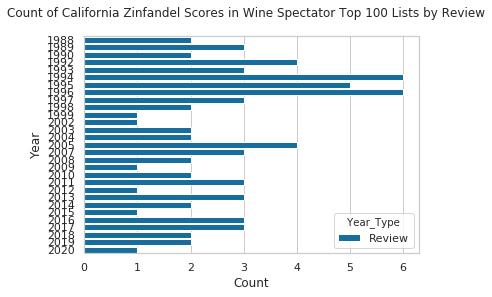

In [316]:
summary_barplot('Review')

### Analysis by Winemaker

In [317]:
# Count of California Zinfandels by Review Year by Winemaker
df_CZW_Count = pd.DataFrame({'Count' : df_Wine_V.groupby(['Winemaker'])['Score'].count()}).reset_index()

# Count of California Zinfandels by Review Year
df_CZW_Price = pd.DataFrame({'Average_Price' : df_Wine_V.groupby(['Winemaker'])['Price'].mean()}).reset_index()

# Count of California Zinfandels by Review Year
df_CZW_Score = pd.DataFrame({'Average_Score' : df_Wine_V.groupby(['Winemaker'])['Score'].mean()}).reset_index()

frame = [df_CZW_Count, df_CZW_Price, df_CZW_Score]
df_CZW = pd.concat(frame, sort = True, axis = 1)
df_CZW = df_CZW.T.drop_duplicates().T

df_CZW

,Winemaker,Count,Average_Price,Average_Score
0,A. Rafanelli,2,8.5,90.5
1,Beaulieu Vineyard,1,13,91
2,Bedrock,1,25,93
3,Boeger,1,10,90
4,Buehler,2,16.5,92
5,Carlisle,5,45,95.2
6,Carol Shelton,1,19,90
7,Cline,1,15,91
8,Dry Creek,2,35,92.5
9,Easton,1,22,92


In [318]:
# define a function to graph summary data

def winemaker():
    
    df = df_CZW
    
    # Make the pairgrid
    g = sns.PairGrid(df.sort_values(by = 'Average_Score', ascending = False),
                     x_vars = df.columns[1:4],
                     y_vars = df.columns[0],
                     height = 10,
                     aspect = 0.25
                    )
    
    # Draw dot plot using stripplot function
    g.map(sns.stripplot,
          size = 10, 
          orient = 'h',
          jitter = False,
          palette = 'colorblind',
          linewidth = 1,
          edgecolor = 'w')
    
    # Use semantically meaningful titles for the columns
    titles = ['Count', 'Average Price', 'Average Score']
    
    for ax, title in zip(g.axes.flat, titles):
        
        # Set a different title for each axis
        
        ax.set(title = title)
        
        # Make the grid horizontal instead of vertical
        ax.xaxis.grid(False)
        ax.yaxis.grid(False)

    sns.despine(left = True, bottom = True)
    
    plt.suptitle('California Zinfandel\nCount, Average Score, and Average Price in Wine Spectator Top 100 Lists\nReview Years 1988-2020', y = 1.1)
    plt.savefig('./images/calzin_dotplot_countscores_byyear.png')

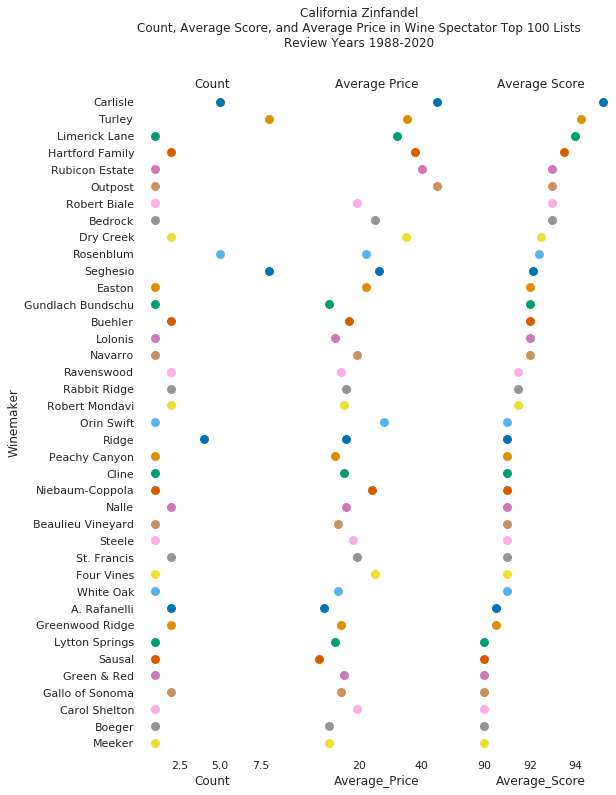

In [319]:
winemaker()